# Import Libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re
import string
import scipy
import time
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer,LineTokenizer
from nltk.stem import LancasterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np
import pandas as pd
np.random.seed(1)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from pomegranate import BayesianNetwork


# Load Video Data

In [2]:
video_df = pd.read_csv("./video_data.csv")
print("Total number of videos : ",len(video_df))

Total number of videos :  5585


In [3]:
video_df.head(4)

,video_id,category_name,short_description,story_text,title
0,5653616771001,Entertainment News,The 34-year-old actor is not sure if he's goin...,Hack: \tThe 34-year-old actor is not sure if h...,Adam Driver still 'undecided' on seeing 'Star ...
1,5631919940001,Entertainment News,The poster gives us a closer look at the actor...,The latest poster of 2.0 featuring Bollywood s...,"BEWARE: Akshay Kumar's look from 2.0 is out, a..."
2,5767901401001,India News,A massive outrage has erupted over the horrifi...,A massive outrage has erupted over the horrifi...,Kathua-Rape-Murder Case: Protesters demand CBI...
3,5741125480001,India News,"According to forensic report, traces of alcoho...",The mystery surrounding Sridevi’s passing away...,Sridevi’s death: Here’s what Amar Singh claims...


# Load co occurrence matrix

In [4]:
with open("./co_occurrence_matrix","rb") as fp:
    matrix = pickle.load(fp)

# 10 unique Genres

In [5]:
print(video_df.category_name.unique())
print(len(video_df.category_name.unique()))

['Entertainment News' 'India News' 'Karnataka Elections 2018' 'World News'
 'Sports News' 'Business News' 'R Bharat' 'Initiatives' 'Technology News'
 'Lifestyle']
10


# Preprocess and clean the textual data

In [6]:
video_df["description"] = video_df["title"]+" "+video_df["short_description"]+" "+video_df["story_text"]

In [7]:
def clean(x):
    temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', x)
    temp = re.sub("[^a-zA-Z]", " ", temp)
    temp = re.sub(' +', ' ', temp).lower()
    return temp

In [8]:
video_df["description_cleaned"] = video_df["description"].map(clean)

# Train multiple LDA models and select with least perplexity

In [9]:
topics = range(8, 13, 1)
perplexities = list()
loglikelihood = list()
lda_list = list()
vec = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=15000,
                                stop_words='english')
tf = vec.fit_transform(video_df["description_cleaned"])

for i in topics:
    print('Computing perplexity for #topics: {}'.format(i))
    lda = LatentDirichletAllocation(n_components=i, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
    
    lda.fit(tf)
    perplexities.append(np.log(lda.perplexity(tf)))
    lda_list.append(lda)

Computing perplexity for #topics: 8
Computing perplexity for #topics: 9
Computing perplexity for #topics: 10
Computing perplexity for #topics: 11
Computing perplexity for #topics: 12


# Perplexity Plot

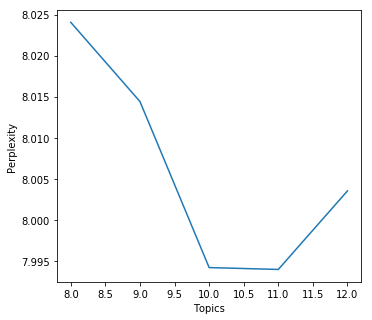

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(topics,perplexities)
plt.xlabel('Topics')
plt.ylabel('Perplexity')
plt.show()

# Select best LDA model

In [11]:
best_lda = lda_list[np.argmin(perplexities)]

In [12]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [13]:
print("\nTopics in LDA model:")
tf_feature_names = vec.get_feature_names()
print_top_words(best_lda, tf_feature_names, 10)


Topics in LDA model:
Topic #0: kapil sharma said mumbai hospital health read police irrfan kumar
Topic #1: said india minister government modi pakistan congress prime president people
Topic #2: film actor shared post khan said bollywood like love read
Topic #3: india rs cricket team indian ipl match players kohli series
Topic #4: khan salman april actor case twitter hai race tiger jodhpur
Topic #5: sridevi kapoor wedding family dubai bollywood daughter actor actress janhvi
Topic #6: said court republic case tv bjp police chief congress minister
Topic #7: deepika singh ranveer padukone padmaavat patel leela khilji boy preity
Topic #8: said world year new time gold air india indian games
Topic #9: bhansali padmavati sena film sanjay release movie tamil leela nadu
Topic #10: twitter facebook rajinikanth com pic award haasan kamal users singer



In [14]:
result = best_lda.transform(tf)
a = np.argwhere(result >= 0.1)
n = range(tf.shape[0])
val1 = [ list(a[a[:,0]==i,1]) for i in n] 
val2 = np.argpartition(-result, 5)[:,0:5]
val = pd.Series(list(zip(val1,val2))).map(lambda x:list(set.intersection(set(x[0]),set(x[1]))))
video_df["topic_list"] = list(val)

In [15]:
video_df.head(4)

,video_id,category_name,short_description,story_text,title,description,description_cleaned,topic_list
0,5653616771001,Entertainment News,The 34-year-old actor is not sure if he's goin...,Hack: \tThe 34-year-old actor is not sure if h...,Adam Driver still 'undecided' on seeing 'Star ...,Adam Driver still 'undecided' on seeing 'Star ...,adam driver still undecided on seeing star war...,[2]
1,5631919940001,Entertainment News,The poster gives us a closer look at the actor...,The latest poster of 2.0 featuring Bollywood s...,"BEWARE: Akshay Kumar's look from 2.0 is out, a...","BEWARE: Akshay Kumar's look from 2.0 is out, a...",beware akshay kumar s look from is out and it ...,[2]
2,5767901401001,India News,A massive outrage has erupted over the horrifi...,A massive outrage has erupted over the horrifi...,Kathua-Rape-Murder Case: Protesters demand CBI...,Kathua-Rape-Murder Case: Protesters demand CBI...,kathua rape murder case protesters demand cbi ...,"[1, 6]"
3,5741125480001,India News,"According to forensic report, traces of alcoho...",The mystery surrounding Sridevi’s passing away...,Sridevi’s death: Here’s what Amar Singh claims...,Sridevi’s death: Here’s what Amar Singh claims...,sridevi s death here s what amar singh claims ...,[5]


In [16]:
video_df[["video_id","topic_list","category_name"]].head()

,video_id,topic_list,category_name
0,5653616771001,[2],Entertainment News
1,5631919940001,[2],Entertainment News
2,5767901401001,"[1, 6]",India News
3,5741125480001,[5],India News
4,5746648010001,"[1, 2]",Entertainment News


# Preprocess the data to meet Pomegranate requirement

In [17]:
def generate_parent_list(df):

    df['video_id_parent_list'] = list(zip(df["topic_list"], df["video_id"]))
    df['topic_parent_list'] = list(zip(df["category_name"], df["topic_list"]))

    node_dict = dict()
    for tup in df["video_id_parent_list"]:
        node_dict[tup[1]] = tup[0]
        
    for tup in df["topic_parent_list"]:
        for topic in tup[1]:
            if topic in node_dict:
                temp_list = node_dict[topic]
                temp_list.append(tup[0])
                node_dict[topic] = list(set(temp_list))
            else:
                node_dict[topic] = [tup[0]]
    
    return node_dict

def generate_node_list(df):
    video_ids = list(df["video_id"])
    flatten = lambda l: [item for sublist in l for item in sublist]
    topics = list(set(flatten(df["topic_list"])))
    categories = list(set(df["category_name"]))
    node_list = video_ids+topics+categories
    return node_list

def generate_structure(parent_dict,node_list):
    structure = list()
    for node in node_list:
        if node in parent_dict:
            parents = parent_dict[node]
            parent_indices = [node_list.index(val) for val in parents]
            res = tuple(parent_indices)
        else:
            res = ()
        structure.append(res)
    return structure
    

In [18]:
parent_dict = generate_parent_list(video_df)
node_list = generate_node_list(video_df)
structure = generate_structure(parent_dict,node_list)
node_list = [str(node) for node in node_list]

# Train the PGM

In [19]:
t0=time.time()
pgm_model = BayesianNetwork.from_structure(matrix, structure=structure,
                                       state_names=node_list)
time.time()-t0

27.54237413406372

# Lets predict

In [20]:
observations = { '5653616771001' : 1, '5767901401001' : 1}

In [21]:
result = pgm_model.predict_proba(observations,max_iterations=2)


In [22]:
res_dict = dict()
for i in range(len(node_list)):
    if node_list[i] not in observations:
        val = result[i].values()[1]
        if val >0.8:
            res_dict[node_list[i]] = val

# Videos to recommend

In [23]:
res_dict

{'5698623820001': 0.8599999999999998,
 '5749634431001': 0.8099999999999999,
 '5745884900001': 0.8199999999999997,
 '5753285778001': 0.8599999999999998,
 '5740702609001': 0.8299999999999997,
 '5766149234001': 0.8099999999999999}